# Evaluation of Figure 2

In this notebook, the data for Figure 2 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import anndata

In [2]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

C:\Users\felix.drost\Anaconda3\envs\mvtcr_4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_model(adata, model, donor):
    path_model = f'saved_models/journal/10x/full/donor_{donor}/{model}_'
    path_model += f'donor_{donor}_full.pt'
    model = utils.load_model(adata, path_model)
    adata.obs['set'] = 'train'
    return model
    

In [4]:
def load_10x_data(donor):
    adata = utils.load_data('10x')
    adata = adata[adata.obs['donor'] == f'donor_{donor}']
    adata = adata[adata.obs['binding_name'].isin(const.donor_1_high_count_antigens)]
    return adata

## Loading

In [5]:
donor = 1

data = load_10x_data(donor)
models = {model_name: load_model(data, model_name, donor) for model_name in ['moe', 'rna', 'tcr', 'poe', 'concat']}

## Latent and UMAPs

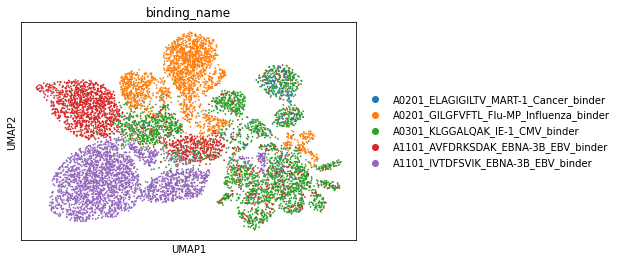

In [6]:
moe_model = models['moe']
latent_moe = moe_model.get_latent(data, metadata=['binding_name', 'clonotype'], return_mean=True)
sc.pp.neighbors(latent_moe, n_neighbors=15, use_rep='X')
sc.tl.umap(latent_moe, min_dist=0.8, spread=0.7)
sc.pl.umap(latent_moe, color='binding_name')

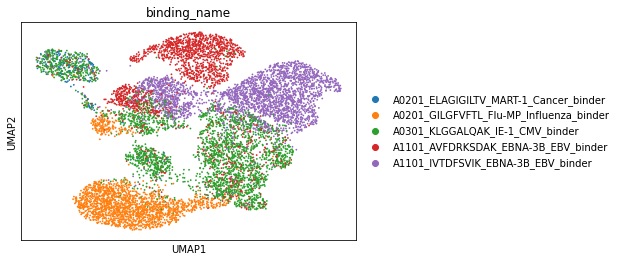

In [7]:
rna_model = models['rna']
latent_rna = rna_model.get_latent(data, metadata=['binding_name', 'clonotype'])
sc.pp.neighbors(latent_rna, n_neighbors=15, use_rep='X')
sc.tl.umap(latent_rna, min_dist=0.7, spread=0.9)
sc.pl.umap(latent_rna, color='binding_name')

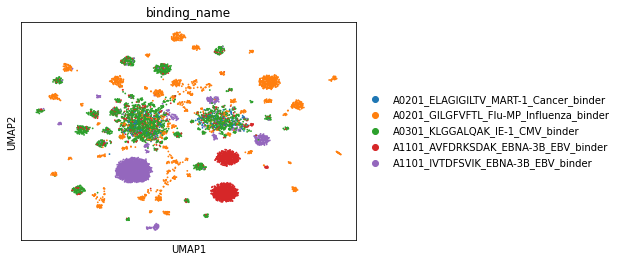

In [8]:
tcr_model = models['tcr']
latent_tcr = tcr_model.get_latent(data, metadata=['binding_name', 'clonotype'])
sc.pp.neighbors(latent_tcr, n_neighbors=10, use_rep='X')
sc.tl.umap(latent_tcr, min_dist=0.9, spread=0.7)
sc.pl.umap(latent_tcr, color='binding_name')

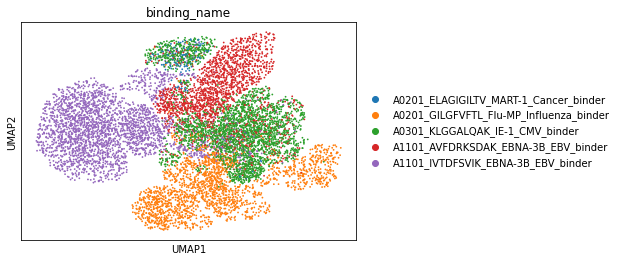

In [9]:
poe_model = models['poe']
latent_poe = poe_model.get_latent(data, metadata=['binding_name', 'clonotype'], return_mean=True)

sc.pp.neighbors(latent_poe, n_neighbors=10, use_rep='X')
sc.tl.umap(latent_poe, min_dist=2, spread=1)
sc.pl.umap(latent_poe, color='binding_name')

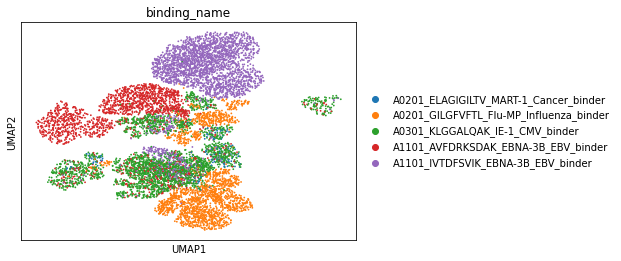

In [10]:
cc_model = models['concat']
latent_cc = cc_model.get_latent(data, metadata=['binding_name', 'clonotype'], return_mean=True)
sc.pp.neighbors(latent_cc, n_neighbors=15, use_rep='X')
sc.tl.umap(latent_cc, min_dist=1, spread=0.5)
sc.pl.umap(latent_cc, color='binding_name')

## Add Marker Genes / Scores

In [11]:
tcell_markers = pd.read_excel('data/41467_2019_12464_MOESM7_ESM.xlsx', skiprows=1)
tcell_markers

,Treg,CD4 NV/CM,CD4/CD8,IFN Response,Proliferation,CD8 Cytotoxic,CD8 Cytokine
0,LRRC32,CTB-133G6.1,WDR86,IFIT3,PYCR1,CCL5,CCL3
1,RGS1,TMEM45B,IL7R,CMPK2,NPW,GZMK,CCL3L3
2,FOXP3,AK5,TSPAN2,IFIT2,LIF,GNLY,CCL4L2
3,RNF207,NOG,LRRC2,IFI44L,IL2,TRGC2,IFNG
4,CTLA4,NGFRAP1,SNAI3,GBP1,SLC29A1,FGFBP2,CCL4
...,...,...,...,...,...,...,...
65,NTRK2,IL24,ITGB7,RTP4,SH2D4A,SETBP1,PRDM1
66,FAM46C,PLCL1,ACSF2,APOL2,YRDC,COLGALT2,KLRD1
67,KLHL5,LETMD1,ATXN7L1,LPP,C10orf2,KIR2DL4,ST8SIA4
68,IZUMO4,SLC8B1,PINK1,SP110,TRAP1,FKBP1B,IER3


In [12]:
def add_scores(latent):
    data = sc.read('../mvTCR/data/10x_CD8TC/logged_10x.h5ad')
    data = data[data.obs['donor']=='donor_1']
    for k, v in tcell_markers.items():
        score_name = k.lower() + "_score"
        data.obs[score_name] = np.mean(
            (
                data[:, [x for x in v if x in data.var_names]].X - 
                data[:, [x for x in v if x in data.var_names]].X.mean(axis=0)
            ) / data[:, [x for x in v if x in data.var_names]].X.todense().std(axis=0),
            axis=1)
        latent.obs[score_name] = data.obs[score_name]

In [13]:
def add_gene(data, latent, gene):
    latent.obs[gene] = np.array(data[:, gene].X.todense())[:, 0]

In [14]:
def add_clonotypes(latent, threshold=100):
    expanded_clonotypes = latent.obs['clonotype'].value_counts()
    expanded_clonotypes = expanded_clonotypes[expanded_clonotypes>=threshold].index
    
    latent.obs['large_clonotype'] = [el if el in expanded_clonotypes
                                  else '-99' 
                                  for el in latent.obs['clonotype']]
    latent.obs['large_clonotype'] = latent.obs['large_clonotype'].astype(str)

In [15]:
for latent in [latent_moe, latent_rna, latent_tcr, latent_poe, latent_cc]:
    for gene in ['IL7R', 'GZMH']:
        add_gene(data, latent, gene)
    add_clonotypes(latent)
    add_scores(latent)

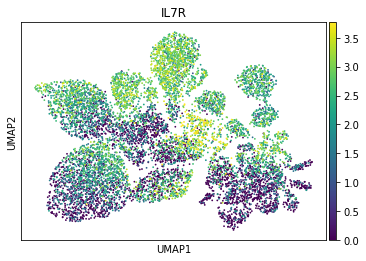

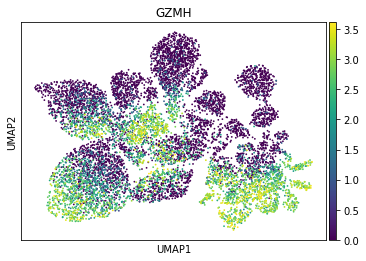

In [16]:
for gene in ['IL7R', 'GZMH']:
    lower, upper = np.percentile(latent_moe.obs[gene], [1, 99])
    sc.pl.umap(latent_moe, color=gene, vmin=lower, vmax=upper)

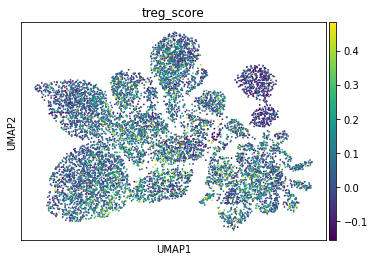

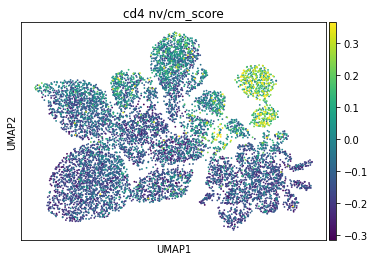

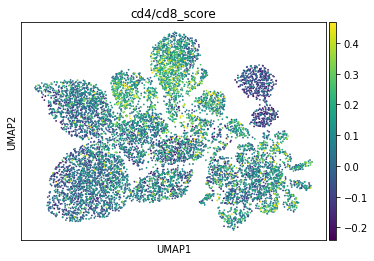

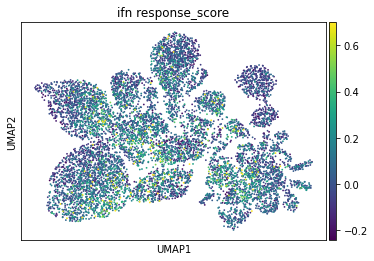

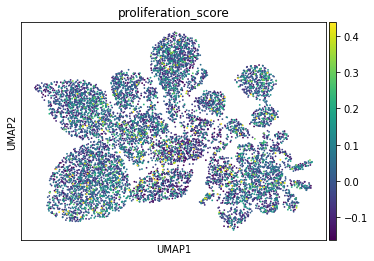

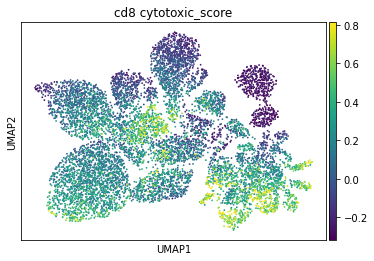

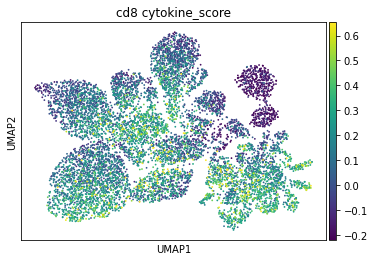

In [17]:
scores = [k.lower() + "_score" for k in tcell_markers]

for score in scores:
    lower, upper = np.percentile(latent_moe.obs[score], [1, 99])
    sc.pl.umap(latent_moe, color=score, vmin=lower, vmax=upper)

In [18]:
sc.write(adata=latent_moe, filename='../results/fig1_moe_d1.h5ad')
sc.write(adata=latent_poe, filename='../results/fig1_poe_d1.h5ad')
sc.write(adata=latent_cc, filename='../results/fig1_cc_d1.h5ad')
sc.write(adata=latent_rna, filename='../results/fig1_rna_d1.h5ad')
sc.write(adata=latent_tcr, filename='../results/fig1_tcr_d1.h5ad')